In [173]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline

np.random.seed(42)

1. Сгенерировать датасет при помощи `sklearn.datasets.make_regression` и обучить линейную модель при помощи градиентного и стохастического градиентного спуска. Нанести среднеквадратичную ошибку для обоих методов на один график, сделать выводы о разнице скорости сходимости каждого из методов.
2. Модифицировать решение первого задания путем добавления $L_{2}$-регуляризации (в функцию, считающую MSE, нужно добавить норму вектора весов) и сравнить результаты.

Our objection is to minimize: $||y - Xw||^2_2 + alpha \cdot ||w||^2_2$ - classic Ridge Regression

In [241]:
X, y = make_regression(n_samples=1300, n_features=5, n_informative=4, noise=15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=300, shuffle=True, random_state=42)

In [242]:
X_st = (X - X.mean(axis=0)) / X.std(axis=0)  # cutom scaling of full dataset

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [6]:
def mserror(X, w, y, a=0):
    y_pred = X.dot(w)
    return np.mean((y - y_pred)**2) + a

In [318]:
def gradient_descent(X, Y, eta=0.01, lambda_=0, max_iter=1e4, penalty='l2'):
    w = np.zeros((X.shape[1]))
    w_list = [w.copy()]
    errors = []
    min_weight_dist = 1e-8
    weight_dist = np.inf
    iter_num = 0
    while weight_dist > min_weight_dist and iter_num < max_iter:
        dL = np.sign(w) if penalty == 'l1' else w
        new_w = w - 2 * eta * (np.dot(X.T, (np.dot(X, w) - Y)) + lambda_*dL) / Y.shape[0]
        weight_dist = np.linalg.norm(new_w - w, ord=2)

        w_list.append(new_w.copy())
        #a = np.linalg.norm(new_w, ord=2) if penalty == 'l2' else np.linalg.norm(new_w, ord=1)
        a = np.sum(np.square(new_w)) if penalty == 'l2' else np.sum(np.abs(new_w))
        errors.append(mserror(X, new_w, Y, lambda_*a))
        iter_num += 1
        w = new_w
    w_list = np.array(w_list)

    print(f'В случае использования градиентного спуска функционал ошибки составляет {round(errors[-1], 4)}')
    
    return w_list, errors

In [315]:
def stochastic_gradient_descent(X, Y, eta=0.01, max_iter=1e5, min_weight_dist=1e-8, lambda_=0, penalty='l2'):
    w = np.random.randn(X.shape[1])
    w_list = [w.copy()]
    errors = []
    weight_dist = np.inf
    iter_num = 0
    lamb = 0.01 
    #Q = [mserror(X, w, Y)]  

    while weight_dist > min_weight_dist and iter_num < max_iter:
    
        train_ind = np.random.randint(X.shape[0])

        dQ = np.dot(X[train_ind:train_ind+1,:].T, (np.dot(X[train_ind:train_ind+1,:], w) - Y[train_ind]))
        dL = np.sign(w) if penalty == 'l1' else w
    
        new_w = w - 2 * eta * (dQ + lambda_*dL) #/ Y.shape[0]  
        weight_dist = np.linalg.norm(new_w - w, ord=2)
    
        w_list.append(new_w.copy())
        #a = np.linalg.norm(new_w, ord=2) if penalty == 'l2' else np.linalg.norm(new_w, ord=1)
        a = np.sum(np.square(new_w)) if penalty == 'l2' else np.sum(np.abs(new_w))

        errors.append(mserror(X, new_w, Y, lambda_*a))
        #Q.append(Q[-1]*(1-lamb)+lamb*(np.dot(X[train_ind,:], w) - Y[train_ind])**2)
        iter_num += 1
        w = new_w
    
    w_list = np.array(w_list)
 
    print(f'В случае использования стохастического градиентного спуска функционал ошибки составляет {round(errors[-1], 4)}')
    return w_list, errors

In [313]:
w_gd, error_gd = gradient_descent(X_train_scaled, y_train, max_iter=1e6, lambda_=0.)

В случае использования градиентного спуска функционал ошибки составляет 257.0164


In [316]:
w_sgd, error_sgd = stochastic_gradient_descent(X_train_scaled, y_train, max_iter=1e5)

В случае использования стохастического градиентного спуска функционал ошибки составляет 265.5905


In [297]:
# проверим долю объясненной моделью дисперсии
pred_train = np.dot(X_train_scaled, w_gd[-1])
pred_test = np.dot(X_test_scaled, w_gd[-1])
print(f'R^2 train: {r2_score(y_train, pred_train):.4f}, R^2 test: {r2_score(y_test, pred_test):.4f}')

R^2 train: 0.9736, R^2 test: 0.9716


In [298]:
# результаты немного разнятся из-за случайного выбора индекса образца
pred_train = np.dot(X_train_scaled, w_sgd[-1])
pred_test = np.dot(X_test_scaled, w_sgd[-1])
print(f'R^2 train: {r2_score(y_train, pred_train):.4f}, R^2 test: {r2_score(y_test, pred_test):.4f}')

R^2 train: 0.9730, R^2 test: 0.9714


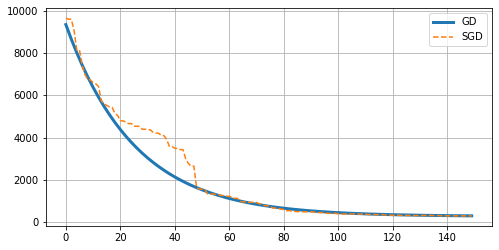

In [299]:
plt.figure(figsize=(8,4))
plt.plot(error_gd[:150], label='GD', lw=3)
plt.plot(error_sgd[:150], label='SGD', ls='--')
plt.grid()
plt.legend()
plt.show()

In [323]:
w_gd, error_gd2 = gradient_descent(X_train_scaled, y_train, max_iter=1e5, lambda_=0.001)
w_sgd, error_sgd2 = stochastic_gradient_descent(X_train_scaled, y_train, max_iter=1e5, lambda_=0.001)

В случае использования градиентного спуска функционал ошибки составляет 266.6998
В случае использования стохастического градиентного спуска функционал ошибки составляет 275.8231


In [321]:
pred_train = np.dot(X_train_scaled, w_gd[-1])
pred_test = np.dot(X_test_scaled, w_gd[-1])
print(f'R^2 train: {r2_score(y_train, pred_train):.4f}, R^2 test: {r2_score(y_test, pred_test):.4f}')

R^2 train: 0.9736, R^2 test: 0.9716


In [324]:
pred_train = np.dot(X_train_scaled, w_sgd[-1])
pred_test = np.dot(X_test_scaled, w_sgd[-1])
print(f'R^2 train: {r2_score(y_train, pred_train):.4f}, R^2 test: {r2_score(y_test, pred_test):.4f}')

R^2 train: 0.9726, R^2 test: 0.9710


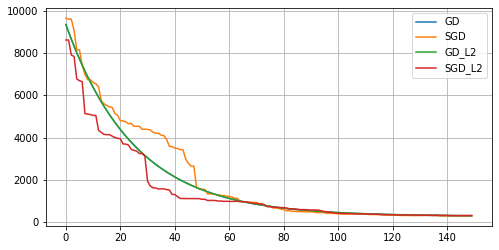

In [303]:
plt.figure(figsize=(8,4))
plt.plot(error_gd[:150], label='GD')
plt.plot(error_sgd[:150], label='SGD')
plt.plot(error_gd2[:150], label='GD_L2')
plt.plot(error_sgd2[:150], label='SGD_L2')
plt.grid()
plt.legend()
plt.show()

### С использованием минибатчей

In [304]:
def eval_sgd_model(X, y, iterations, qty_in_batch, alpha=1e-4, l2=0):
    W = np.random.randn(X.shape[1])
    n = X.shape[0]
    n_batch = n // qty_in_batch
    errors = []
    if n % qty_in_batch != 0:
        n_batch += 1

    for i in range(1, iterations+1):
        batch_errors = []
        for b in range(n_batch):
            start_ = qty_in_batch*b
            end_ = qty_in_batch*(b+1)

            X_tmp = X[start_ : end_, :]
            y_tmp = y[start_ : end_]

            y_pred_tmp = np.dot(X_tmp, W)
            
            W -= alpha * (2/X_tmp.shape[0] * np.dot(X_tmp.T, (y_pred_tmp - y_tmp)) + l2*W)

            l2_term = l2 * np.sum(np.square(W)) # np.linalg.norm(W, ord=2) 
            err = mserror(X, W, y, l2_term)

            batch_errors.append(err)

        #errors.append(np.array(batch_errors).mean())

    return W, batch_errors

In [305]:
W, errors_batch = eval_sgd_model(X_train_scaled, y_train, qty_in_batch=50, iterations=1000, alpha=0.001, l2=0.)
W_reg, errors_batch_reg = eval_sgd_model(X_train_scaled, y_train, qty_in_batch=50, iterations=1000, alpha=0.001, l2=0.001)

In [306]:
pred_train = np.dot(X_train_scaled, W)
pred_test = np.dot(X_test_scaled, W)
print(f'R^2 train: {r2_score(y_train, pred_train):.4f}, R^2 test: {r2_score(y_test, pred_test):.4f}')

R^2 train: 0.9736, R^2 test: 0.9716


In [307]:
pred_train = np.dot(X_train_scaled, W_reg)
pred_test = np.dot(X_test_scaled, W_reg)
print(f'R^2 train: {r2_score(y_train, pred_train):.4f}, R^2 test: {r2_score(y_test, pred_test):.4f}')

R^2 train: 0.9736, R^2 test: 0.9716


Вообще ожидалось, что в модели с применением стохастического градиентного градиентного спуска схождение идет медленнее. В данном случае идентично модели, обновлящей все веса в каждой итерации. С введением регуляризации схождение еще больше замедляется, но при хорошем подборе значения параметра регуляризации мы можем ожидать снижение степени переобучения модели.

In [308]:
pipe_raw = make_pipeline(StandardScaler(), LinearRegression())
pipe_reg = make_pipeline(StandardScaler(), Ridge(alpha=15.)) # the bigger alpha the higher l2 impact on cost fn

pipe_raw.fit(X_train, y_train)
pipe_reg.fit(X_train, y_train)

pred_train_raw = pipe_raw.predict(X_train)
pred_test_raw = pipe_raw.predict(X_test)

pred_train_reg = pipe_reg.predict(X_train)
pred_test_reg = pipe_reg.predict(X_test)

print(f'R^2 raw train: {r2_score(y_train, pred_train_raw):.4f}, R^2 raw test: {r2_score(y_test, pred_test_raw):.4f}')
print(f'R^2 reg train: {r2_score(y_train, pred_train_reg):.4f}, R^2 reg test: {r2_score(y_test, pred_test_reg):.4f}')

R^2 raw train: 0.9747, R^2 raw test: 0.9730
R^2 reg train: 0.9744, R^2 reg test: 0.9722


In [309]:
# weights gentle cut-off
pipe_raw[-1].coef_, pipe_reg[-1].coef_

(array([68.69913027, 33.4695397 , 57.87699055, 22.20137922,  0.9667528 ]),
 array([67.6415282 , 33.02836704, 56.99377932, 21.83380468,  0.90430783]))

### Проверка

In [289]:
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Xt = torch.as_tensor(X_train_scaled, dtype=torch.float32).to(device)
yt = torch.as_tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

model = nn.Sequential(nn.Linear(5, 1),).to(device)

opt = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01) 
loss_fn = nn.MSELoss()

model.train()

for i in range(1000):
    opt.zero_grad()

    out = model(Xt)
    loss = loss_fn(out, yt)
    loss.backward()
    opt.step()

    if (i+1) % 100 == 0:
        print(f'MSE loss = {loss.item():.6f}')

MSE loss = 445.963013
MSE loss = 252.198807
MSE loss = 246.898972
MSE loss = 246.590500
MSE loss = 246.555695
MSE loss = 246.550812
MSE loss = 246.550125
MSE loss = 246.550140
MSE loss = 246.550140
MSE loss = 246.550140


In [290]:
model.eval()
Xt_test = torch.as_tensor(X_test_scaled, dtype=torch.float32)
y_pred_train_logits = model(Xt)
y_pred_test_logits = model(Xt_test)

In [291]:
torch_test = y_pred_test_logits.squeeze().detach().cpu().numpy()
torch_train = y_pred_train_logits.squeeze().detach().cpu().numpy()

print(f'R^2 train: {r2_score(y_train, torch_train):.4f}, R^2 test: {r2_score(y_test, torch_test):.4f}')

R^2 train: 0.9746, R^2 test: 0.9728
